In [1]:
import pandas as pd
import numpy as np

import yfinance as yf
from datetime import date



import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')


In [2]:
indice = "BZ=F" # Preço do barril de petróleo Brent

inicio = "2014-01-01" 
data_ref = date.today() - pd.Timedelta(days=-1)
final = data_ref.isoformat() 
df = yf.download(indice, inicio, final)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,110.800003,111.320000,107.690002,107.779999,107.779999,5131
2014-01-03,107.919998,108.620003,106.779999,106.889999,106.889999,5641
2014-01-06,107.040001,107.949997,106.580002,106.730003,106.730003,7015
2014-01-07,107.180000,107.709999,106.910004,107.349998,107.349998,4075
2014-01-08,107.449997,107.919998,107.010002,107.150002,107.150002,5124
...,...,...,...,...,...,...
2024-05-14,83.500000,83.620003,82.099998,82.379997,82.379997,33169
2024-05-15,82.769997,83.070000,81.059998,82.750000,82.750000,41744
2024-05-16,82.930000,83.779999,82.309998,83.269997,83.269997,27576


In [4]:
df['ds']= df.index
df= df[['ds', 'Close']]
df.rename(columns= {'Close' : 'Preço'}, inplace=True)
df.rename(columns= {'ds' : 'Data'}, inplace=True)
df.head()

,Data,Preço
Date,,
2014-01-02,2014-01-02,107.779999
2014-01-03,2014-01-03,106.889999
2014-01-06,2014-01-06,106.730003
2014-01-07,2014-01-07,107.349998
2014-01-08,2014-01-08,107.150002


In [5]:
px.line(df, x='Data', y='Preço', title='Série Temporal').update_xaxes(rangeslider_visible=True)


In [6]:
df.to_csv('data/ipea.csv', index=False)


In [7]:
# É uma boa prática criar recursos de atraso (lag features) para séries temporais
# Vamos criar alguns para nosso modelo
# Criar recursos de atraso (lag features)
lags = 7
for lag in range(1, lags + 1):
    df[f'Preço_lag_{lag}'] = df['Preço'].shift(lag)

In [8]:
# Removemos quaisquer linhas com valores NaN que foram criados ao fazer o shift
df = df.dropna()
# Preparando os dados para treinamento
X = df[['Preço']].values  # Inputs são os preços atrasados
y = df['Preço'].values  # Output é o preço atual

In [9]:

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

In [10]:
# Criar e treinar o modelo de Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, 
                                        random_state=42, loss='squared_error')
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

In [11]:
# Fazer previsões
predictions = model.predict(X_test)

In [12]:

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error: 1.08
Mean Absolute Error: 0.26


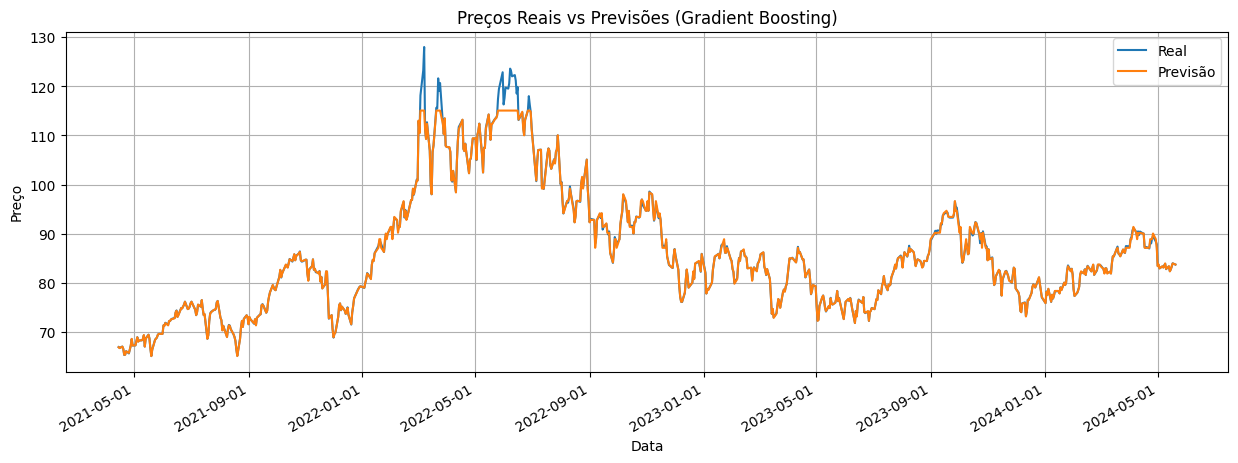

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(df['Data'].iloc[-len(y_test):], y_test, label='Real')
plt.plot(df['Data'].iloc[-len(predictions):], predictions, label='Previsão')
# Melhorar a formatação do eixo x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatar as datas como 'Ano-Mês-Dia'
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())             # Escolher automaticamente a localização das datas
# Melhorar a legibilidade girando as datas e ajustando o espaçamento
plt.gcf().autofmt_xdate()  # Gira as datas para evitar sobreposição
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.title('Preços Reais vs Previsões (Gradient Boosting)')
plt.show()

In [14]:
#Salvar o modelo treinado
with open('model.pkl', 'wb') as up:
    pickle.dump(model, up)